Epoch 1/50 - Train Loss: 29980.8169, Val Loss: 28621.9739
Epoch 2/50 - Train Loss: 29804.1682, Val Loss: 28472.7437
Epoch 3/50 - Train Loss: 29627.4243, Val Loss: 28267.8201
Epoch 4/50 - Train Loss: 29422.4674, Val Loss: 28130.9172
Epoch 5/50 - Train Loss: 29188.4492, Val Loss: 27905.1902
Epoch 6/50 - Train Loss: 28923.7934, Val Loss: 27562.4157
Epoch 7/50 - Train Loss: 28611.7787, Val Loss: 27213.4472
Epoch 8/50 - Train Loss: 28200.3814, Val Loss: 26927.8962
Epoch 9/50 - Train Loss: 27703.2983, Val Loss: 26243.6761
Epoch 10/50 - Train Loss: 27030.9657, Val Loss: 25693.1148
Epoch 11/50 - Train Loss: 26597.8597, Val Loss: 25818.8577
Epoch 12/50 - Train Loss: 26540.9931, Val Loss: 25735.9932
Epoch 13/50 - Train Loss: 26467.7993, Val Loss: 25730.3053
Epoch 14/50 - Train Loss: 26411.6937, Val Loss: 25714.6637
Epoch 15/50 - Train Loss: 26345.0088, Val Loss: 25432.4190
Epoch 16/50 - Train Loss: 26306.5447, Val Loss: 25327.9149
Epoch 17/50 - Train Loss: 26233.6049, Val Loss: 25417.0139
Epoch 

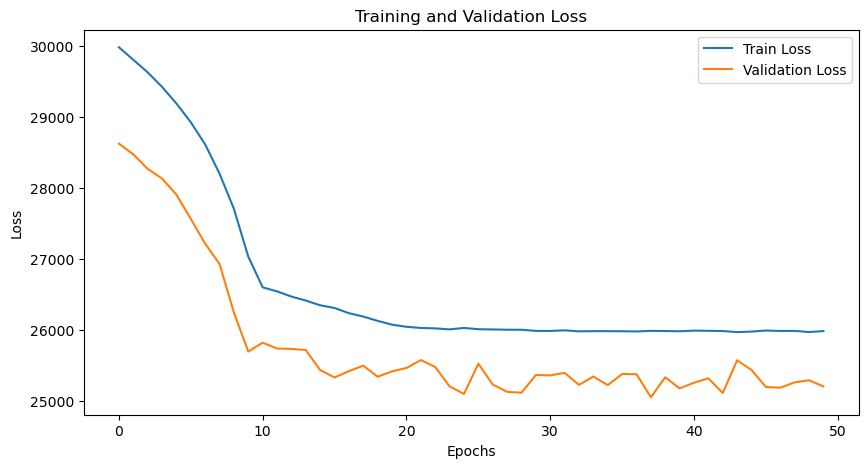

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden1 = nn.Linear(17, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.hidden2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.hidden3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.hidden4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu4 = nn.ReLU()
        
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.hidden1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.hidden2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.hidden3(x))))
        x = self.relu4(self.batch_norm4(self.hidden4(x)))
        x = self.output(x)
        return x

# Initialize the model
model = RegressionModel()

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Data Preparation
df = pd.read_csv('../Data/dataset83.csv')
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

df.fillna(df.mean(), inplace=True)

X = df.drop('wing_loading', axis=1).values
y = df['wing_loading'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

num_epochs = 50
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test Loss: 26061.7638
tensor([[-1.0299e+00,  7.1028e-01,  1.5453e+00, -1.6157e+00,  4.2526e-03,
          5.1838e-01, -1.1914e+00, -1.0075e+00,  8.8835e-01,  9.7932e-01,
          7.4906e-01,  6.7319e-01,  7.1186e-01,  7.1064e-01,  6.0644e-01,
          9.4430e-01,  5.4352e-01],
        [ 9.7096e-01,  1.2289e-03, -1.4738e+00,  1.3343e+00, -1.2226e+00,
         -1.5790e+00,  1.2696e+00,  9.9252e-01,  6.8759e-01,  4.8985e-01,
          7.1175e-01,  5.0133e-01,  5.8277e-01,  5.8165e-01,  2.0181e-01,
          4.3845e-01,  2.6463e-01],
        [-1.0299e+00,  7.1028e-01,  1.5453e+00, -1.6157e+00,  1.2311e+00,
         -1.2294e+00,  3.9097e-02, -1.0075e+00,  2.7065e-01, -3.6822e-01,
         -1.0235e+00, -2.1738e-01, -4.6119e-01, -4.5591e-01, -3.2421e-01,
         -2.0792e-01, -4.8281e-01],
        [ 9.7096e-01,  1.4193e+00, -2.0694e-01,  2.8541e-01,  4.2526e-03,
         -1.8074e-01,  1.2696e+00,  9.9252e-01, -7.4855e-01, -5.3994e-02,
         -5.5704e-01, -3.5018e-01, -4.1629e-01, -4.1665e

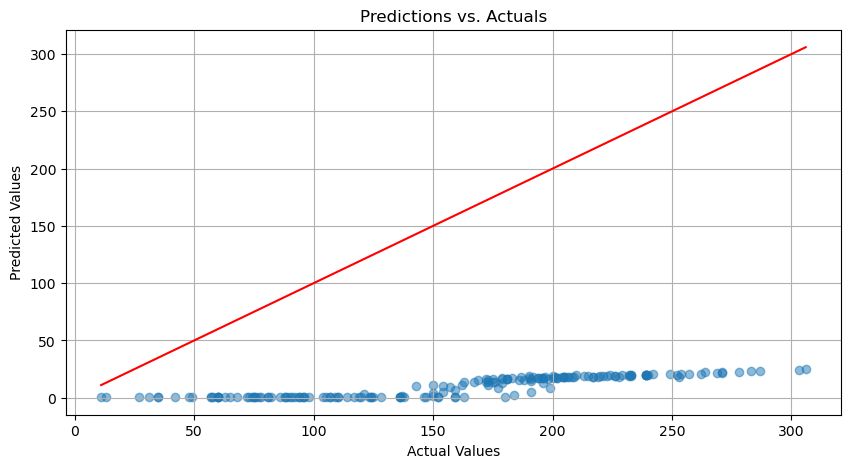

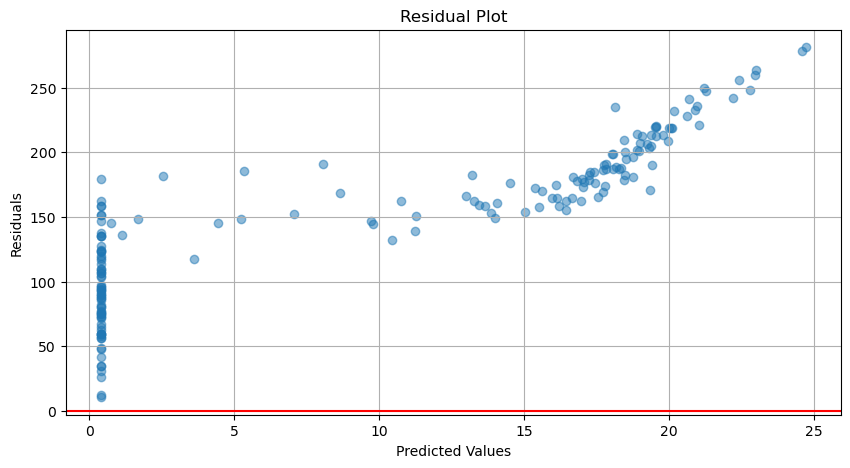

In [20]:
# Evaluate the model on the test dataset
test_loss = validate_epoch(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')

# Predictions vs. Actual plot
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        print(inputs)
        print(labels)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(labels.view(-1).tolist())
    print(predictions)
    print(actuals)

plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')  # Line showing perfect predictions
plt.title('Predictions vs. Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Residual Plot
residuals = [act - pred for act, pred in zip(actuals, predictions)]
plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()